# Prompt

First, you learned about the importance of transforming your data into a stationary series. You tested for stationarity using the adfuller function and interpreted the value of the hypothesis test. If the data was not stationary, you learned how to apply strategies, such as differencing and logarithmic transformations, to achieve stationarity.

Once the series was stationary, building an ARMA model involved using autocorrelation and partial autocorrelation plots to determine the appropriate p and q parameters of the model.

This activity asks you to identify a time series of interest to you and build an ARMA model to construct a basic forecast for the series and analyze the error. You might also consider building models with different p and q parameters because, while ACF and PACF plots are helpful, they provide rough ideas of the appropriate parameters, and it is usually good practice to perform a simple grid search on these. 

Please find a time series dataset using any resource you would like, and present your model and findings to the class.  

If you have trouble locating a dataset or would prefer a suggestion, try the [Rossmann Store Sales](https://www.kaggle.com/c/rossmann-store-sales) from Kaggle. This dataset involves forecasting retail store sales for a major drug store.

# Imports

In [1]:
import warnings
import statsmodels.api as sm
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import numpy as np

from statsmodels.tsa.seasonal import seasonal_decompose, _extrapolate_trend
from statsmodels.tsa.filters.filtertools import convolution_filter
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf, plot_predict
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.tsa.forecasting.stl import STLForecast

from sklearn.metrics import root_mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
import seaborn as sns

In [2]:
warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", None)
mpl.rcParams.update({"axes.grid": True})
sns.set()

# Data Load

Looking at snowfall per month for Mammoth Mountain, from 1969 to the present, as obtained from  
- https://www.mammothmountain.com/on-the-mountain/snowfall-history

See [pre-processing notebook](./mammoth_snowfall_datagen.ipynb) for how I generated this table from the Mammoth website data

In [3]:
df = pd.read_csv("./data/mammoth_mountain_snowfall_melted_table.csv")
df.head()

,Date,Month,Snow Fall
0,1970-01-01,Jan,78.0
1,1970-02-01,Feb,30.5
2,1970-03-01,Mar,46.0
3,1970-04-01,Apr,27.0
4,1970-05-01,May,0.0


In [4]:
df["Date"] = pd.to_datetime(df["Date"])
df = df.set_index("Date")
df.head()

,Month,Snow Fall
Date,,
1970-01-01,Jan,78.0
1970-02-01,Feb,30.5
1970-03-01,Mar,46.0
1970-04-01,Apr,27.0
1970-05-01,May,0.0


In [31]:
df.tail()

,Month,Snow Fall
Date,,
2023-08-01,Aug,0.0
2023-09-01,Sep,0.0
2023-10-01,Oct,0.0
2023-11-01,Nov,14.0
2023-12-01,Dec,12.0


# All Data

Arbitrarily limit from 2015 and on, to make the dataset easier to work with

In [69]:
y_target = df["Snow Fall"]["2014":"2022-05-01"]

## Plot

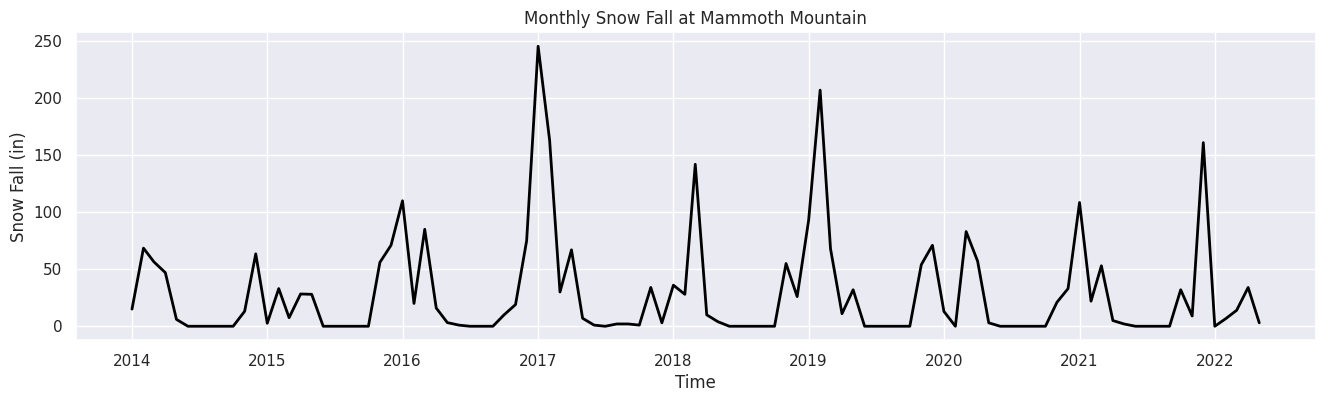

In [70]:
plt.figure(figsize=(16, 4))
plt.plot(y_target, color="black", lw=2)
plt.title("Monthly Snow Fall at Mammoth Mountain")
plt.xlabel("Time")
plt.ylabel("Snow Fall (in)")
plt.show()

In [28]:
def plot_acf_pacf(y):
    (fig, ax) = plt.subplots(nrows=1, ncols=2, figsize=(16, 4))
    plot_acf(y, lags=10, ax=ax[0])
    ax[0].set_title("ACF - MA(q)")
    ax[0].set_xlabel("Lag")
    ax[0].set_ylabel("Corr")

    plot_pacf(y, lags=10, ax=ax[1])
    ax[1].set_title("PACF - AR(p)")
    ax[1].set_xlabel("Lag")
    ax[1].set_ylabel("Corr")
    plt.show()

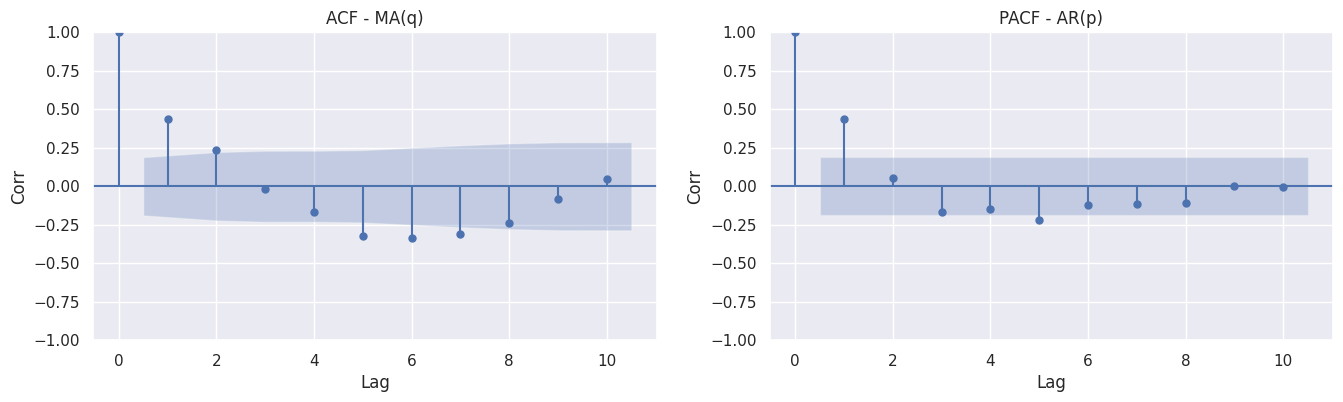

In [29]:
plot_acf_pacf(y_target)

In [30]:
display(adfuller(y_target))

(-5.878720874117554,
 3.114791557932713e-07,
 4,
 103,
 {'1%': -3.4954932834550623,
  '5%': -2.8900369024285117,
  '10%': -2.5819706975209726},
 998.6674547092329)

# Train / Test Split

In [71]:
n_steps_future = 7
(y_history, y_future) = train_test_split(
    y_target, shuffle=False, test_size=n_steps_future
)
(y_exog, y_exog_history, y_exog_future) = (None, None, None)

# Remove Seasonal with STL

In [50]:
period = 12
# decomposed = seasonal_decompose(
#     y_history,
#     model="additive",
#     period=period,
#     extrapolate_trend=period,
# )

# decomposed.plot()
# plt.show()

In [72]:
stl = STL(y_history, period=period).fit()
y_stl_fit = stl.trend + stl.seasonal

In [73]:
stlf = STLForecast(
    y_history, ARIMA, model_kwargs={"order": (1, 1, 0), "trend": "t"}, period=period
).fit()
y_stl_forecast = stlf.forecast(n_steps_future)
y_stl_forecast.index = y_future.index

In [75]:
y_stl = pd.concat([y_stl_fit, y_stl_forecast])

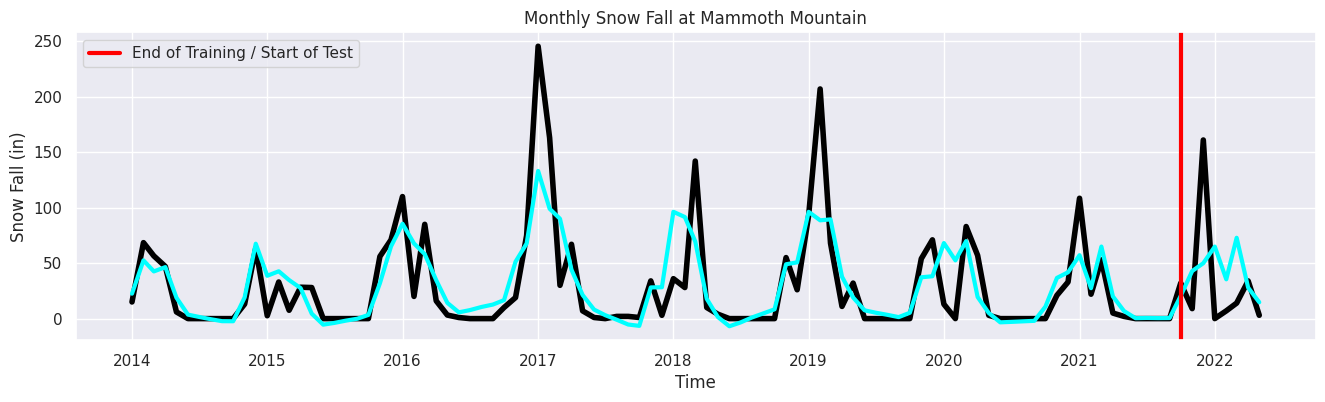

In [76]:
plt.figure(figsize=(16, 4))
plt.plot(y_target, color="black", lw=4)
# plt.plot(y_stl_fit, color="blue", lw=3)
# plt.plot(y_stl_forecast, color="cyan", lw=3)
plt.plot(y_stl, color="cyan", lw=3)
plt.axvline(
    y_history.tail(1).index, color="red", label="End of Training / Start of Test", lw=3
)
plt.title("Monthly Snow Fall at Mammoth Mountain")
plt.legend(loc="upper left")
plt.xlabel("Time")
plt.ylabel("Snow Fall (in)")
plt.show()

# New Target is The Seasonal Residue

In [77]:
y_target_res = y_target - y_stl

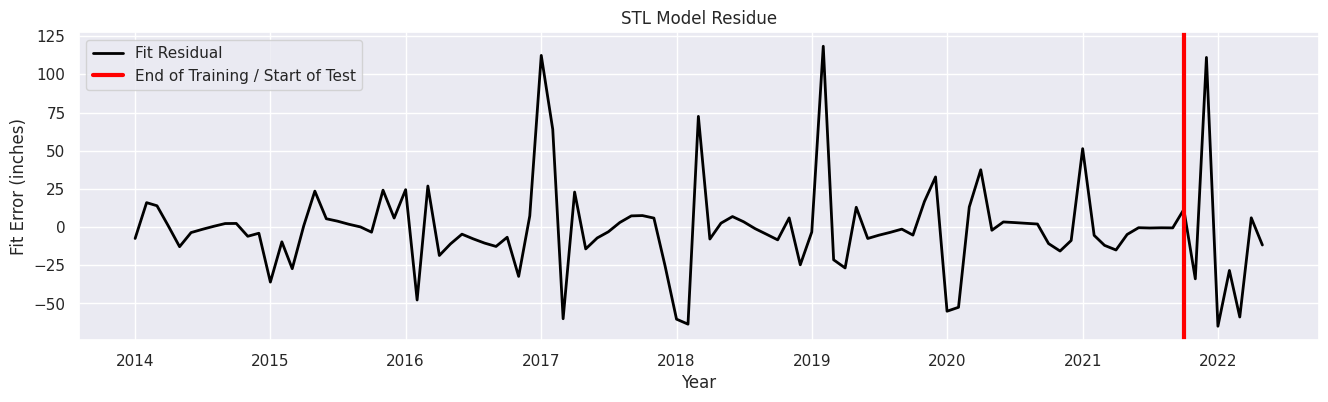

In [78]:
plt.figure(figsize=(16, 4))
plt.plot(y_target_res, color="black", lw=2, label="Fit Residual")
plt.title("STL Model Residue")
plt.xlabel("Year")
plt.ylabel("Fit Error (inches)")
plt.axvline(
    y_history.tail(1).index, color="red", label="End of Training / Start of Test", lw=3
)
plt.legend(loc="upper left")
plt.show()

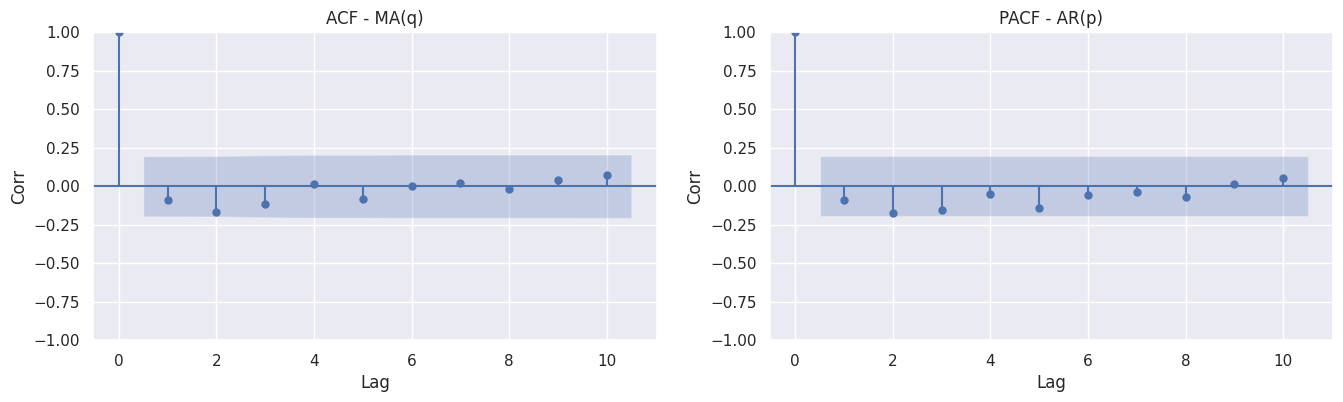

In [81]:
plot_acf_pacf(y_target_res)

# Fit with ARIMA

In [83]:
def get_train_test_errors(y_target, y_hat, n_steps_future):
    (y_history, y_future, y_fit, y_forecast) = train_test_split(
        y_target, y_hat, shuffle=False, test_size=n_steps_future
    )

    mae_fit = mean_absolute_error(y_history, y_fit)
    rmse_fit = root_mean_squared_error(y_history, y_fit)

    mae_forecast = mean_absolute_error(y_future, y_forecast)
    rmse_forecast = root_mean_squared_error(y_future, y_forecast)

    return dict(
        zip(
            ["mae_fit", "rmse_fit", "mae_forecast", "rmse_forecast"],
            [mae_fit, rmse_fit, mae_forecast, rmse_forecast],
        )
    )

In [84]:
def get_estimator_and_errors(y_target, n_steps_future, order_p_d_q, seasonal_order):
    estimator = ARIMA(
        y_history,
        order=order_p_d_q,
        seasonal_order=seasonal_order,
        exog=y_exog_history,
    ).fit()

    # Compute all history, plus future forecast
    y_hat = estimator.predict(
        start=y_target.index[0], end=y_target.index[-1], exog=y_exog_future
    )

    train_test_errors = get_train_test_errors(y_target, y_hat, n_steps_future)
    return estimator, y_hat, train_test_errors

In [87]:
p_list = range(1, 3)
d_list = [0]  # range(0, 2)
q_list = range(1, 4)

best_error = np.Inf
best_order_p_d_q = None

seasonal_order = (0, 0, 0, 0)

for p in p_list:
    for q in q_list:
        for d in d_list:
            order_p_d_q = (p, d, q)
            estimator, y_hat, train_test_errors = get_estimator_and_errors(
                y_target_res, n_steps_future, order_p_d_q, seasonal_order
            )
            error_to_minimize = train_test_errors["rmse_forecast"]
            # error_to_minimize = train_test_errors["rmse_fit"]

            if error_to_minimize < best_error:
                best_error = error_to_minimize
                best_order_p_d_q = order_p_d_q
                print(
                    "New best at order_p_d_q = %s with errors:\n\t%s"
                    % (str(order_p_d_q), str(train_test_errors))
                )

New best at order_p_d_q = (1, 0, 1) with errors:
	{'mae_fit': 32.80736900266707, 'rmse_fit': 43.251879475046664, 'mae_forecast': 63.818830743258715, 'rmse_forecast': 68.2529581589212}
New best at order_p_d_q = (1, 0, 2) with errors:
	{'mae_fit': 32.83173942468506, 'rmse_fit': 43.31564176818017, 'mae_forecast': 63.75872947195749, 'rmse_forecast': 68.1803935477013}


In [88]:
order_p_d_q = best_order_p_d_q
estimator, y_hat, train_test_errors = get_estimator_and_errors(
    y_target_res, n_steps_future, order_p_d_q, seasonal_order
)
display(best_order_p_d_q)
display(train_test_errors)

(1, 0, 2)

{'mae_fit': 32.83173942468506,
 'rmse_fit': 43.31564176818017,
 'mae_forecast': 63.75872947195749,
 'rmse_forecast': 68.1803935477013}

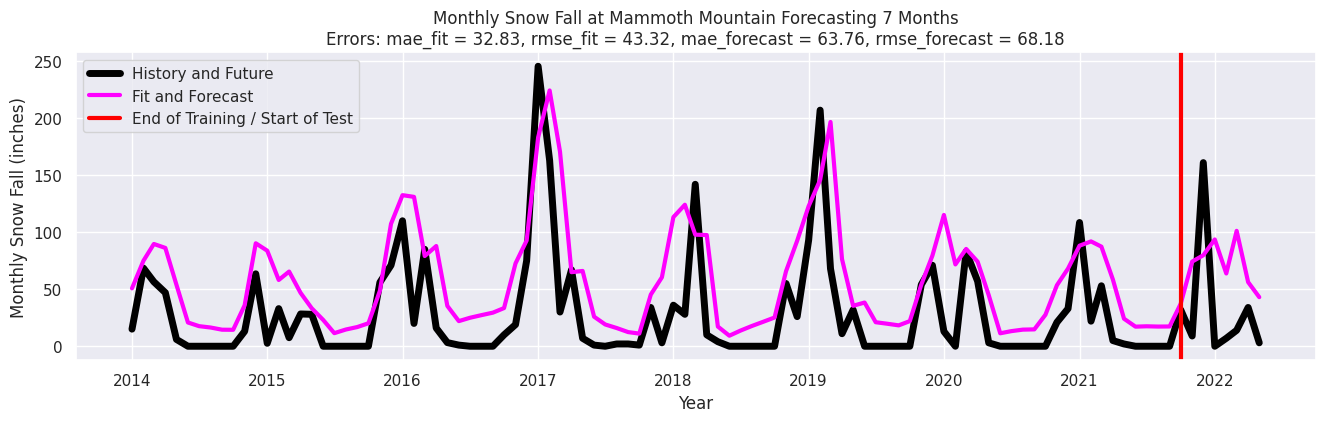

In [97]:
nplot = n_steps_future
nplot = 3 * n_steps_future
nplot = len(y_history)
plt.figure(figsize=(16, 4))
plt.plot(
    y_target,
    color="black",
    label="History and Future",
    lw=5,
)
plt.plot(y_stl + y_hat, color="magenta", label="Fit and Forecast", lw=3)
plt.axvline(
    y_history.index[-1], color="red", label="End of Training / Start of Test", lw=3
)

errors_str = ", ".join(["%s = %.2f" % (k, v) for k, v in train_test_errors.items()])
plt.title(
    "Monthly Snow Fall at Mammoth Mountain Forecasting %d Months\nErrors: %s"
    % (n_steps_future, errors_str)
)

plt.xlabel("Year")
plt.ylabel("Monthly Snow Fall (inches)")
plt.legend(loc="upper left")
plt.show()

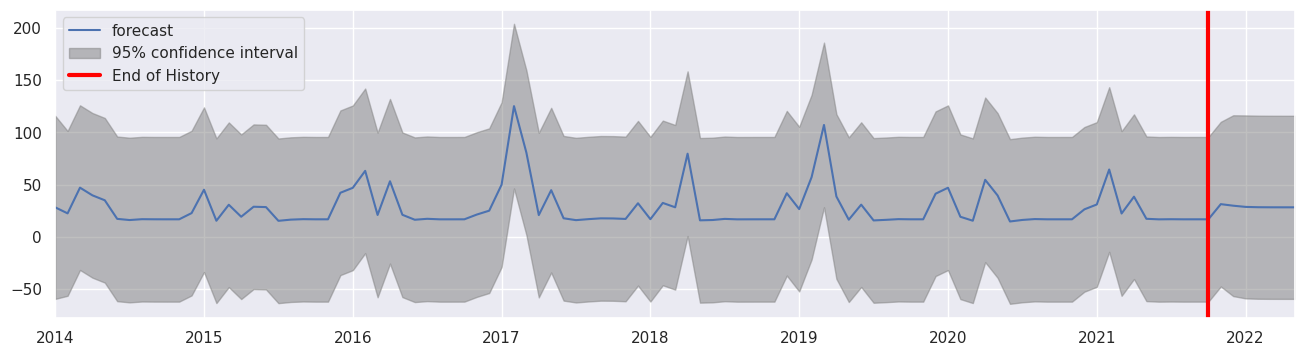

In [98]:
fig, ax = plt.subplots(figsize=(16, 4))
fig = plot_predict(
    estimator,
    start=y_history.index[0],
    end=y_future.index[-1],
    ax=ax,
    exog=y_exog_future,
)
plt.axvline(y_history.index[-1], color="red", label="End of History", lw=3)
legend = ax.legend(loc="upper left")
plt.show()

## Plot Residue

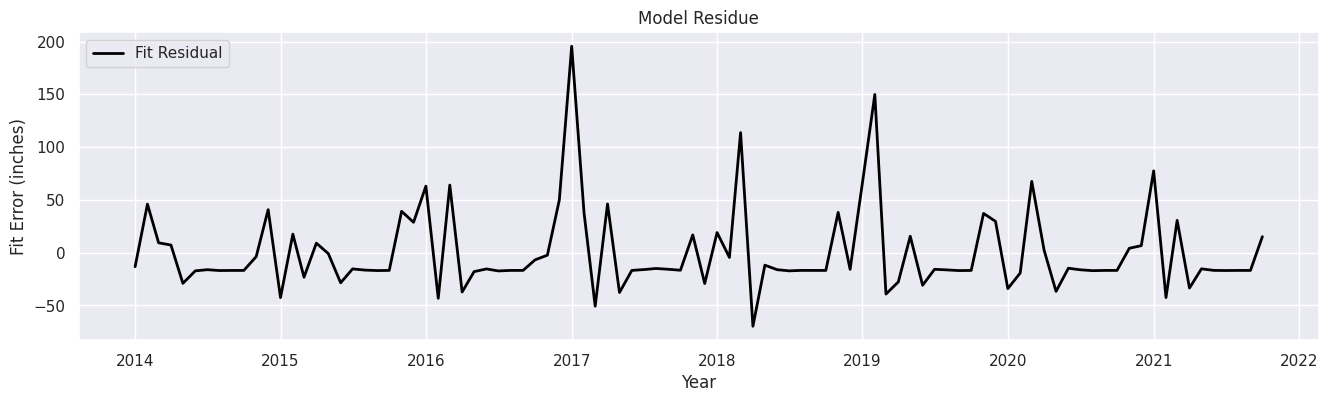

In [93]:
plt.figure(figsize=(16, 4))
plt.plot(estimator.resid, color="black", lw=2, label="Fit Residual")
plt.title("Model Residue")
plt.xlabel("Year")
plt.ylabel("Fit Error (inches)")
plt.legend(loc="upper left")
plt.show()

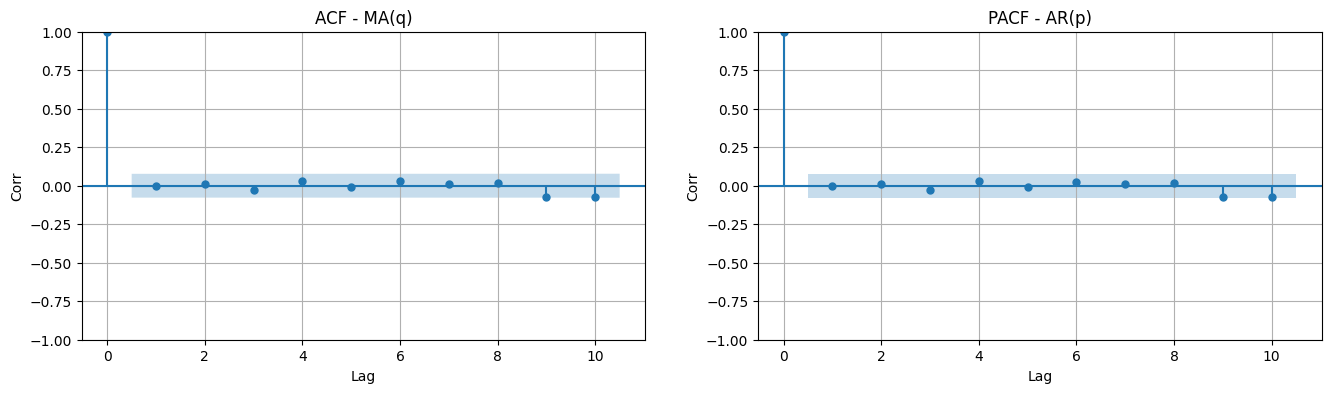

In [27]:
plot_acf_pacf(estimator.resid)

In [28]:
display(adfuller(estimator.resid))

(-25.39773957656231,
 0.0,
 0,
 641,
 {'1%': -3.4405928713433735,
  '5%': -2.866059505075432,
  '10%': -2.5691768365293113},
 6091.0260150388995)